In [1]:
#Import some libraries
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
# from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier as cat
from sklearn.metrics import roc_auc_score,log_loss
from sklearn.metrics import precision_score
# from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
path = './'

In [3]:
#import data
train_df=pd.read_csv(path+'/reduced_train.csv')
test_df =  pd.read_csv(path+'/reduced_test.csv')
submission = pd.read_csv(path+'/SampleSubmission.csv')

In [4]:
train_df.shape,test_df.shape,submission.shape

((7160, 36), (3069, 36), (3068, 2))

In [5]:
train_df.head()

,Building Dimension,Building Dimension_null,Building_Fenced,Building_Painted,Building_Type_1,Building_Type_2,Building_Type_3,Building_Type_4,Date_of_Occupancy,Date_of_Occupancy_freq,...,gb_feature_Date_of_Occupancy_Building Dimension,gb_feature_Geo_Code_Building Dimension,gb_feature_Geo_Code_Building Dimension_diff,gb_feature_Insured_Period_Building Dimension,gb_feature_NumberOfWindows_Building Dimension,gb_feature_Occupancy_bins_Building Dimension,gb_feature_Period_Flag_Building Dimension,gb_feature_YOBSERV_Building Dimension,Customer Id,Claim
0,5.673323,0,1,0,1,0,0,0,1960.0,0.257308,...,1287.829042,979.0,-689.0,1797.354714,1577.719460,1997.830558,1797.354714,1776.132698,H14663,0.0
1,6.196444,0,0,1,1,0,0,0,1900.0,0.183791,...,1157.440354,979.0,-489.0,1797.354714,1746.940865,1157.440354,1797.354714,1805.202570,H2037,0.0
2,6.390241,0,1,0,1,0,0,0,1960.0,0.257308,...,1287.829042,979.0,-384.0,1797.354714,1577.719460,1997.830558,1797.354714,1905.850686,H3802,0.0
3,7.951911,0,1,1,1,0,0,0,1960.0,0.257308,...,1287.829042,979.0,1861.0,1797.354714,1577.719460,1997.830558,1797.354714,1776.132698,H3834,0.0
4,6.523562,0,0,1,1,0,0,0,1900.0,0.183791,...,1157.440354,979.0,-299.0,1797.354714,1227.922502,1157.440354,1797.354714,1905.850686,H5053,0.0


In [6]:
train= train_df.copy()
test = test_df.copy()
submission = test_df.copy()

In [7]:
submission = test_df[['Customer Id','Claim']]

In [8]:
submission.head()

,Customer Id,Claim
0,H11920,NaN
1,H11921,NaN
2,H9805,NaN
3,H7493,NaN
4,H7494,NaN


In [9]:
target = train.Claim.copy()
group = train['YearOfObservation'].copy()
train.drop(['Claim','Customer Id'],axis=1, inplace=True)


test.drop(['Claim','Customer Id'], axis=1, inplace=True)
test = test.reset_index(drop=True)

In [10]:
train.shape,test.shape,submission.shape

((7160, 34), (3069, 34), (3069, 2))

In [11]:
from sklearn.model_selection import StratifiedGroupKFold


In [12]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost','lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict



        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 300, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedGroupKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label,groups=group)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sb.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

================================Fold1====================================
0:	test: 0.6619583	best: 0.6619583 (0)	total: 53.1ms	remaining: 8m 51s
50:	test: 0.7151753	best: 0.7151753 (50)	total: 256ms	remaining: 50s
100:	test: 0.7214504	best: 0.7214735 (99)	total: 460ms	remaining: 45.1s
150:	test: 0.7245673	best: 0.7246382 (148)	total: 669ms	remaining: 43.6s
200:	test: 0.7263968	best: 0.7263968 (200)	total: 894ms	remaining: 43.6s
250:	test: 0.7266785	best: 0.7269405 (232)	total: 1.11s	remaining: 43.1s
300:	test: 0.7276653	best: 0.7277164 (298)	total: 1.31s	remaining: 42.4s
350:	test: 0.7283367	best: 0.7283367 (350)	total: 1.52s	remaining: 41.8s
400:	test: 0.7279528	best: 0.7285096 (365)	total: 1.72s	remaining: 41.3s
450:	test: 0.7285558	best: 0.7285558 (450)	total: 1.96s	remaining: 41.5s
500:	test: 0.7286316	best: 0.7286513 (495)	total: 2.2s	remaining: 41.8s
550:	test: 0.7286497	best: 0.7286925 (503)	total: 2.44s	remaining: 41.9s
600:	test: 0.7284273	best: 0.7286925 (503)	total: 2.64s	re

50:	test: 0.6982288	best: 0.6983700 (48)	total: 221ms	remaining: 43.1s
100:	test: 0.7055976	best: 0.7055976 (100)	total: 437ms	remaining: 42.9s
150:	test: 0.7102755	best: 0.7103061 (149)	total: 668ms	remaining: 43.6s
200:	test: 0.7126484	best: 0.7126774 (198)	total: 941ms	remaining: 45.9s
250:	test: 0.7140666	best: 0.7141839 (248)	total: 1.14s	remaining: 44.1s
300:	test: 0.7145274	best: 0.7148386 (288)	total: 1.35s	remaining: 43.6s
350:	test: 0.7148735	best: 0.7148735 (350)	total: 1.56s	remaining: 42.8s
400:	test: 0.7153496	best: 0.7153955 (398)	total: 1.76s	remaining: 42.2s
450:	test: 0.7151234	best: 0.7156250 (418)	total: 1.97s	remaining: 41.6s
500:	test: 0.7146966	best: 0.7156250 (418)	total: 2.17s	remaining: 41s
550:	test: 0.7148854	best: 0.7156250 (418)	total: 2.36s	remaining: 40.5s
600:	test: 0.7141576	best: 0.7156250 (418)	total: 2.58s	remaining: 40.4s
650:	test: 0.7133176	best: 0.7156250 (418)	total: 2.79s	remaining: 40.1s
700:	test: 0.7129554	best: 0.7156250 (418)	total: 3.01s

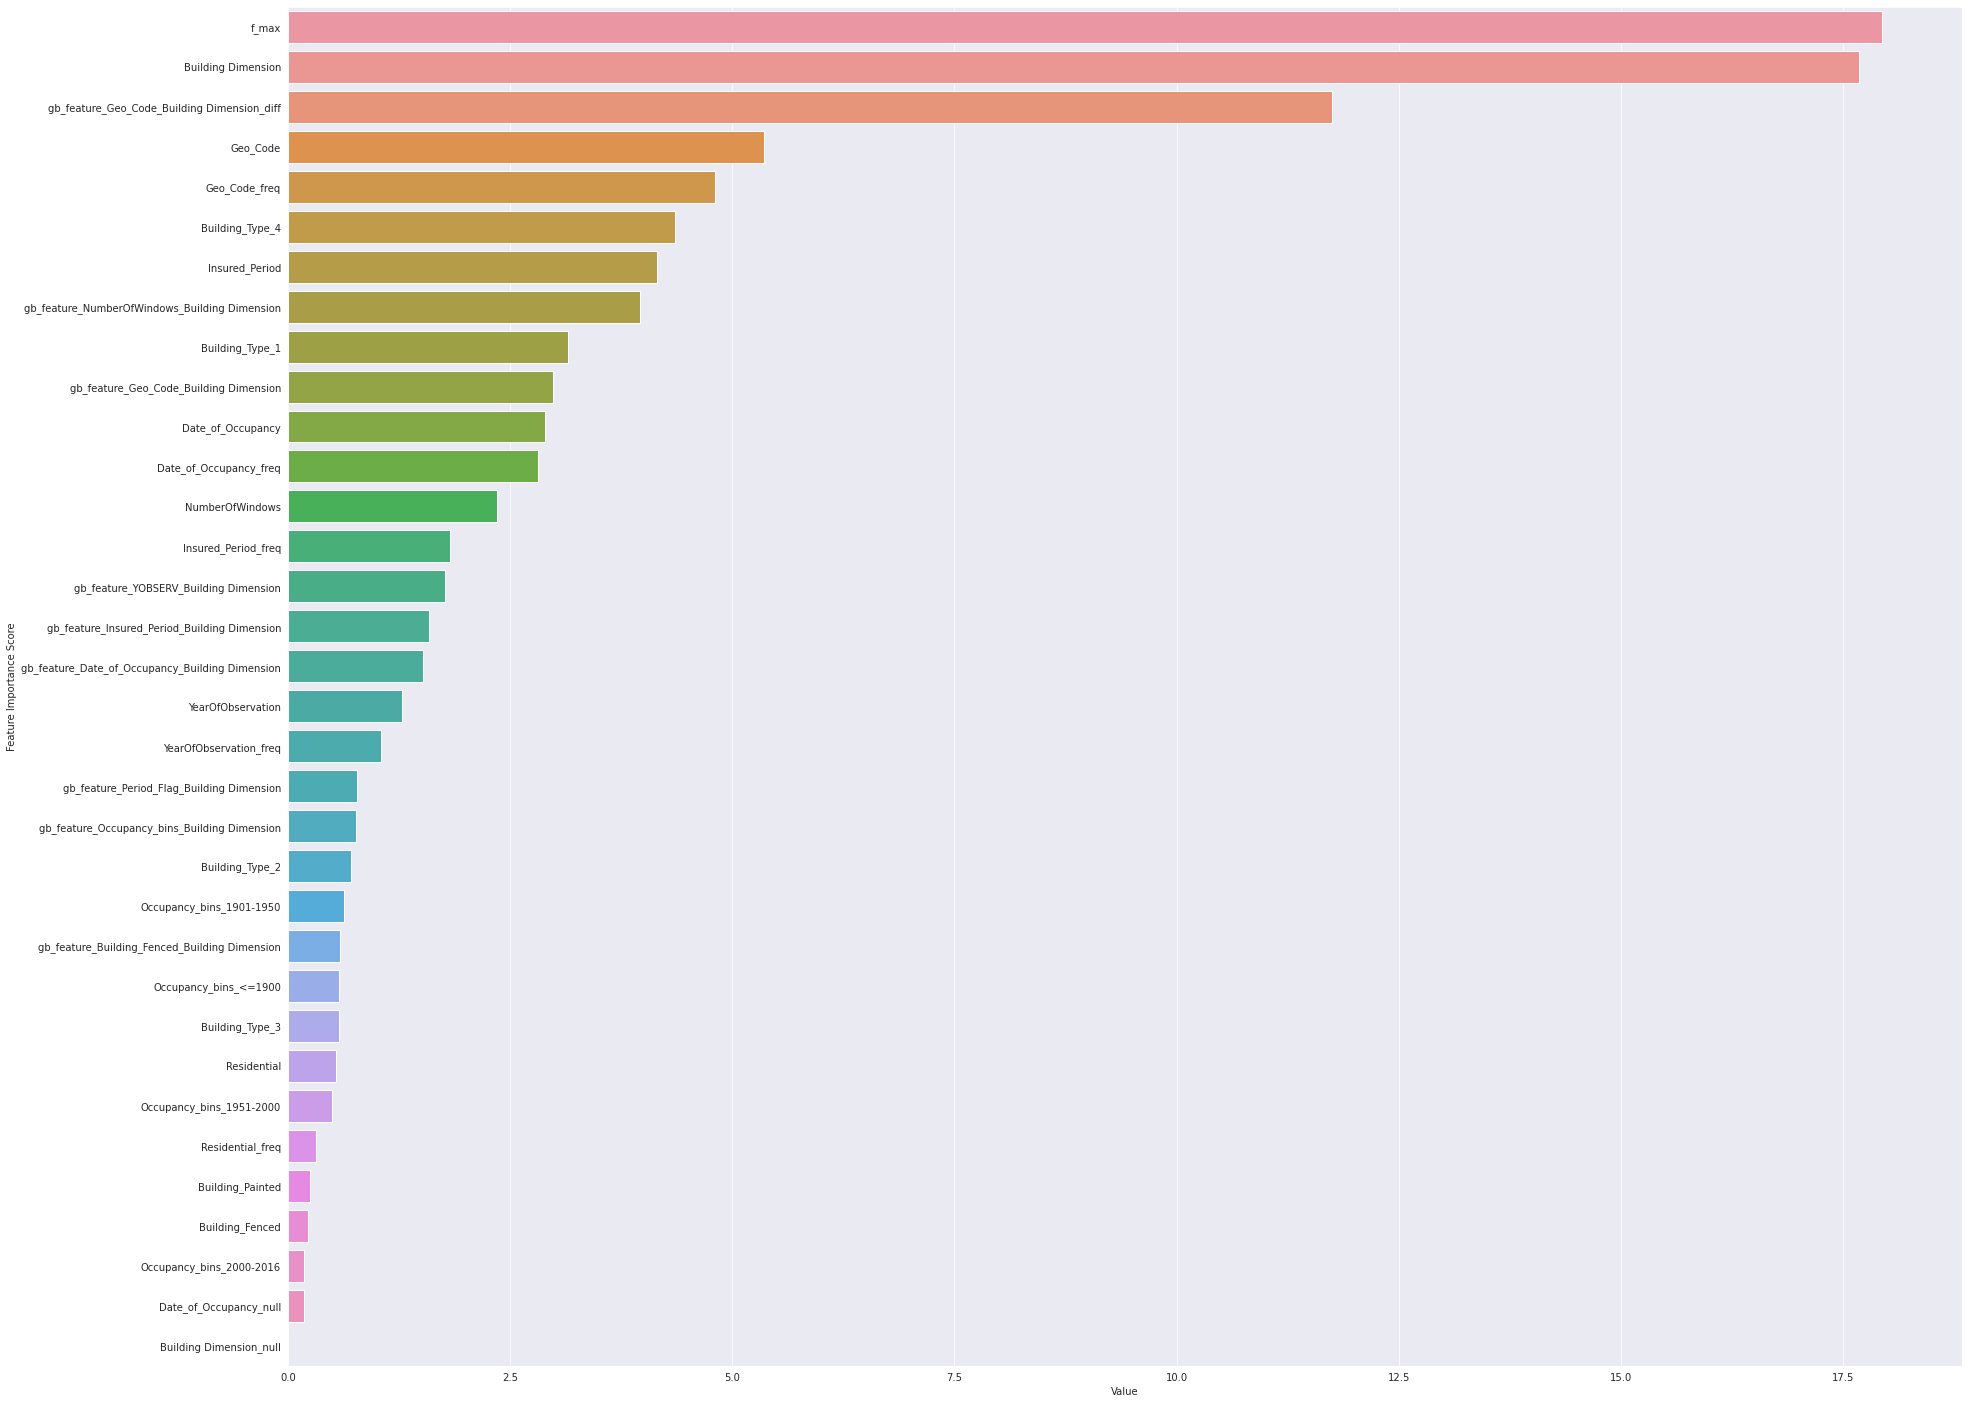

0.7233929355352953 0.7733429837548177 0.007966649348593797


In [13]:
catboost = cat(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370)#

func_= func(train, target, test, catboost, 'catboost', 16)
val_p1, test_p1, model1 = func_()

================================Fold1====================================
Learning rate set to 0.017573
0:	test: 0.6814343	best: 0.6814343 (0)	total: 3.78ms	remaining: 37.8s
50:	test: 0.7222198	best: 0.7239067 (14)	total: 202ms	remaining: 39.3s
100:	test: 0.7264471	best: 0.7268433 (98)	total: 392ms	remaining: 38.4s
150:	test: 0.7270714	best: 0.7277840 (121)	total: 581ms	remaining: 37.9s
200:	test: 0.7278408	best: 0.7279330 (195)	total: 785ms	remaining: 38.3s
250:	test: 0.7273886	best: 0.7279816 (219)	total: 973ms	remaining: 37.8s
300:	test: 0.7269817	best: 0.7279816 (219)	total: 1.16s	remaining: 37.4s
350:	test: 0.7262354	best: 0.7279816 (219)	total: 1.36s	remaining: 37.4s
400:	test: 0.7262288	best: 0.7279816 (219)	total: 1.55s	remaining: 37s
450:	test: 0.7257543	best: 0.7279816 (219)	total: 1.73s	remaining: 36.7s
500:	test: 0.7254644	best: 0.7279816 (219)	total: 1.96s	remaining: 37.2s
550:	test: 0.7242996	best: 0.7279816 (219)	total: 2.17s	remaining: 37.3s
600:	test: 0.7237692	best: 0

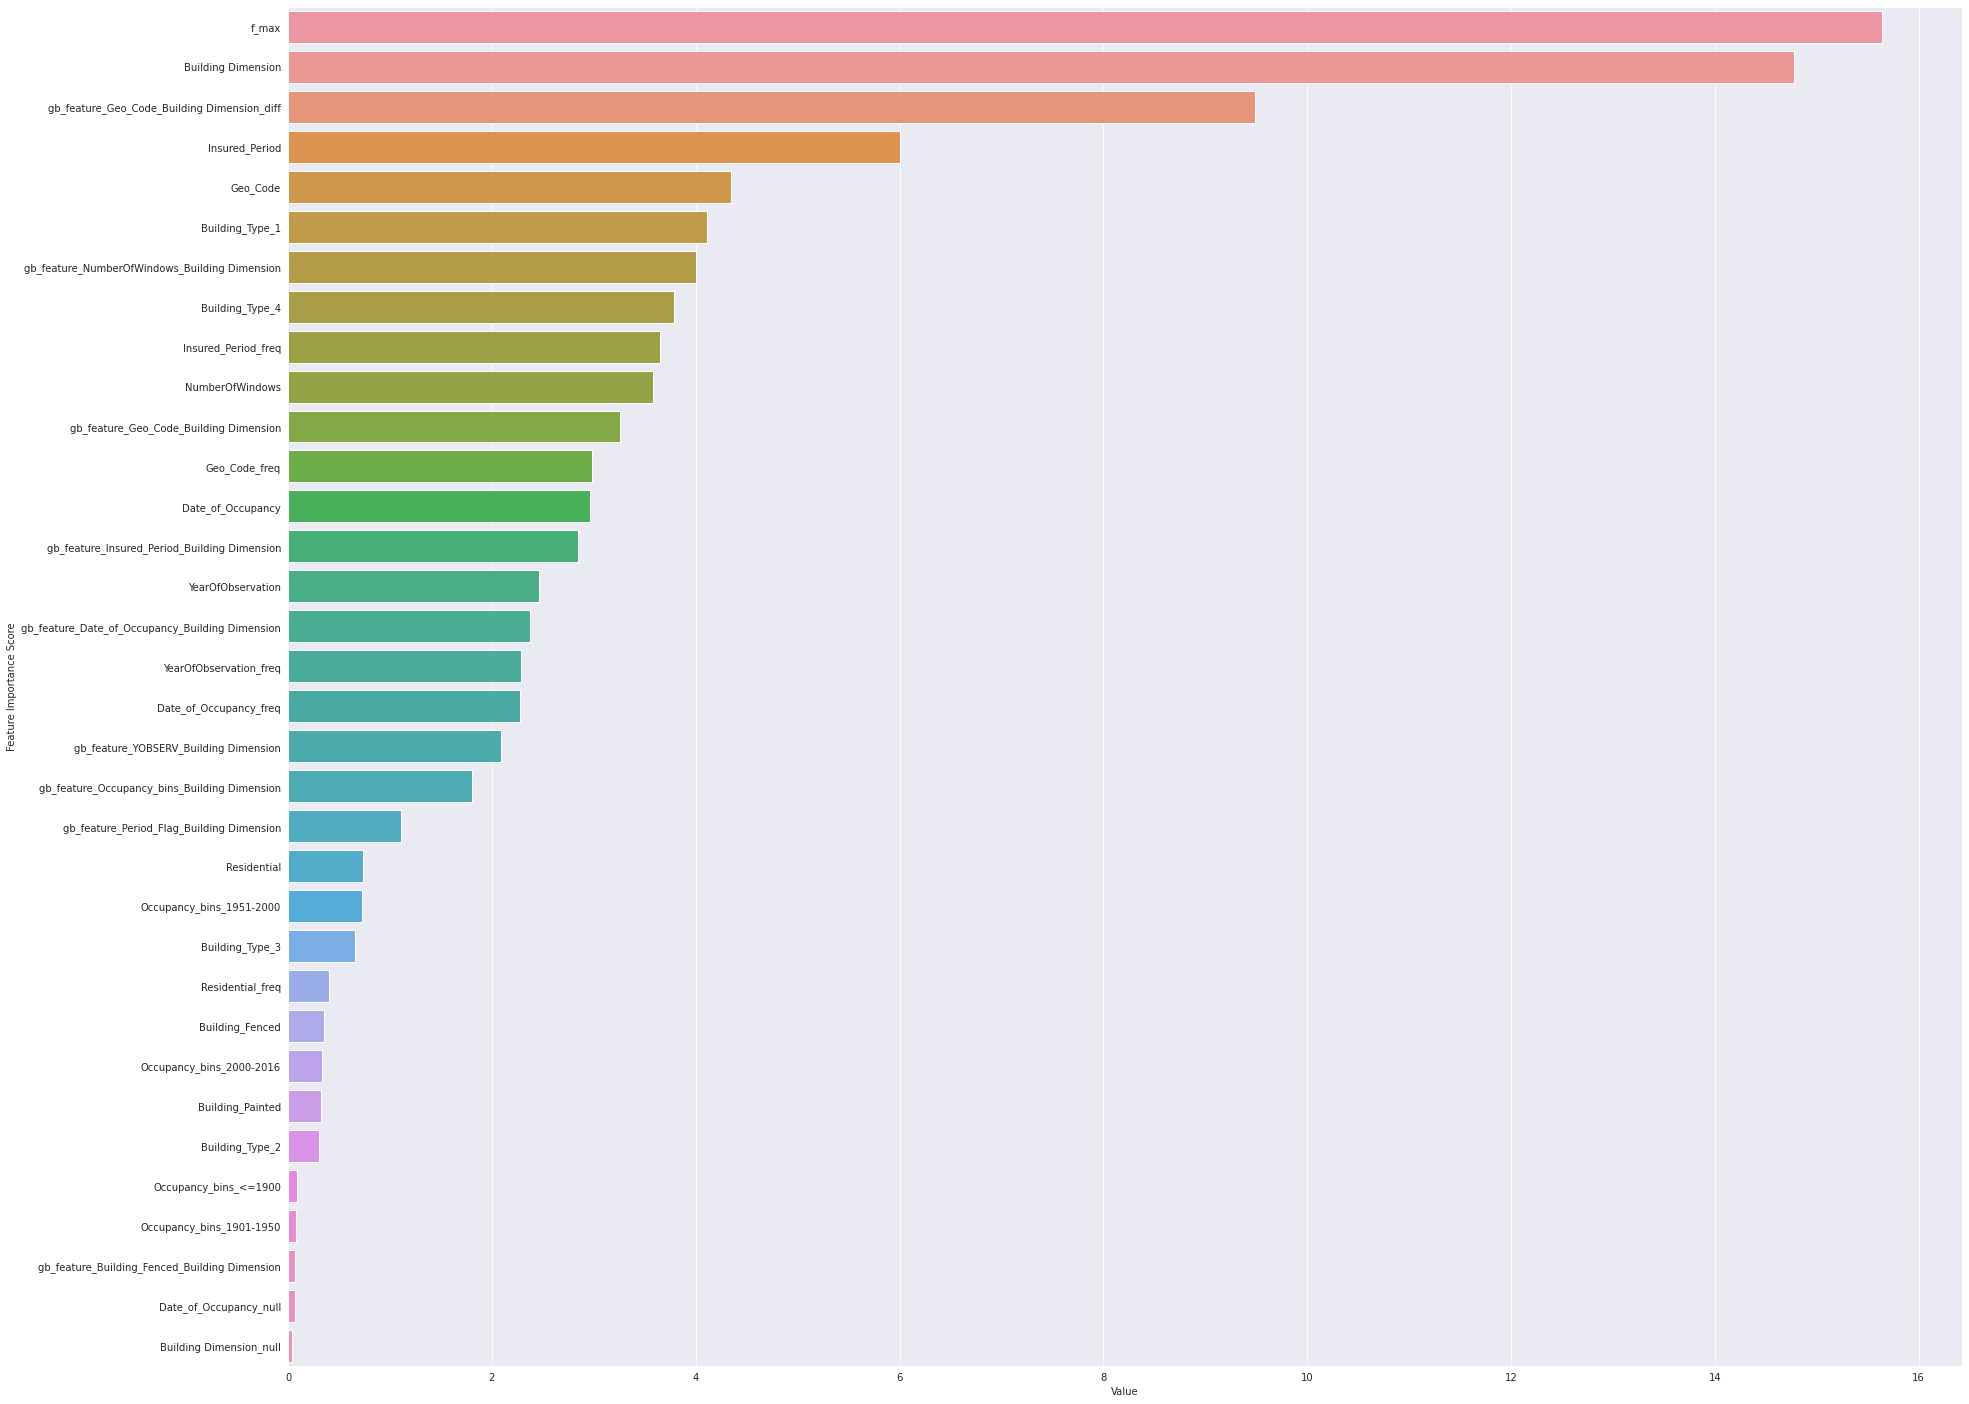

0.7245358722233884 0.7921765268611167 0.008871980008019703


In [14]:
#catboost = cat(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1',random_state=21)
catboost= cat(bootstrap_type='Bernoulli', 
                              iterations=10000, silent=True, eval_metric='AUC')#,task_type="GPU", devices='0:1'
func_= func(train, target, test, catboost, 'catboost', 32)
val_p2, test_p2, model2 = func_()

================================Fold1====================================
[1]	valid_0's auc: 0.691859
[2]	valid_0's auc: 0.695578
[3]	valid_0's auc: 0.700706
[4]	valid_0's auc: 0.699545
[5]	valid_0's auc: 0.700623
[6]	valid_0's auc: 0.698212
[7]	valid_0's auc: 0.701962
[8]	valid_0's auc: 0.698983
[9]	valid_0's auc: 0.700759
[10]	valid_0's auc: 0.701987
[11]	valid_0's auc: 0.705451
[12]	valid_0's auc: 0.707857
[13]	valid_0's auc: 0.710193
[14]	valid_0's auc: 0.711345
[15]	valid_0's auc: 0.711132
[16]	valid_0's auc: 0.711469
[17]	valid_0's auc: 0.712918
[18]	valid_0's auc: 0.714464
[19]	valid_0's auc: 0.715639
[20]	valid_0's auc: 0.716497
[21]	valid_0's auc: 0.716988
[22]	valid_0's auc: 0.717447
[23]	valid_0's auc: 0.717394
[24]	valid_0's auc: 0.717523
[25]	valid_0's auc: 0.717567
[26]	valid_0's auc: 0.717658
[27]	valid_0's auc: 0.716953
[28]	valid_0's auc: 0.716217
[29]	valid_0's auc: 0.716438
[30]	valid_0's auc: 0.716858
[31]	valid_0's auc: 0.716813
[32]	valid_0's auc: 0.717478
[33]	va

[286]	valid_0's auc: 0.698638
[287]	valid_0's auc: 0.699026
[288]	valid_0's auc: 0.699223
[289]	valid_0's auc: 0.699152
[290]	valid_0's auc: 0.699011
[291]	valid_0's auc: 0.698909
[292]	valid_0's auc: 0.699037
[293]	valid_0's auc: 0.698612
[294]	valid_0's auc: 0.69853
[295]	valid_0's auc: 0.698409
[296]	valid_0's auc: 0.698605
[297]	valid_0's auc: 0.698599
[298]	valid_0's auc: 0.69878
[299]	valid_0's auc: 0.698793
[300]	valid_0's auc: 0.698535
[301]	valid_0's auc: 0.698564
[302]	valid_0's auc: 0.698691
[303]	valid_0's auc: 0.698693
[304]	valid_0's auc: 0.698624
[305]	valid_0's auc: 0.698579
[306]	valid_0's auc: 0.698717
[307]	valid_0's auc: 0.6989
[308]	valid_0's auc: 0.698877
[309]	valid_0's auc: 0.699083
[310]	valid_0's auc: 0.699108
[311]	valid_0's auc: 0.699166
[312]	valid_0's auc: 0.699133
[313]	valid_0's auc: 0.698955
[314]	valid_0's auc: 0.698795
[315]	valid_0's auc: 0.69896
[316]	valid_0's auc: 0.698876
[317]	valid_0's auc: 0.698874
[318]	valid_0's auc: 0.69905
[319]	valid_0's 

[232]	valid_0's auc: 0.701478
[233]	valid_0's auc: 0.70094
[234]	valid_0's auc: 0.700641
[235]	valid_0's auc: 0.700535
[236]	valid_0's auc: 0.700436
[237]	valid_0's auc: 0.700826
[238]	valid_0's auc: 0.701045
[239]	valid_0's auc: 0.701165
[240]	valid_0's auc: 0.700789
[241]	valid_0's auc: 0.70078
[242]	valid_0's auc: 0.700851
[243]	valid_0's auc: 0.700957
[244]	valid_0's auc: 0.701049
[245]	valid_0's auc: 0.7011
[246]	valid_0's auc: 0.700807
[247]	valid_0's auc: 0.700622
[248]	valid_0's auc: 0.70046
[249]	valid_0's auc: 0.700138
[250]	valid_0's auc: 0.699814
[251]	valid_0's auc: 0.699825
[252]	valid_0's auc: 0.699517
[253]	valid_0's auc: 0.699329
[254]	valid_0's auc: 0.699315
[255]	valid_0's auc: 0.698959
[256]	valid_0's auc: 0.698797
[257]	valid_0's auc: 0.698669
[258]	valid_0's auc: 0.698569
[259]	valid_0's auc: 0.698211
[260]	valid_0's auc: 0.698074
[261]	valid_0's auc: 0.698245
[262]	valid_0's auc: 0.698341
[263]	valid_0's auc: 0.69835
[264]	valid_0's auc: 0.698401
[265]	valid_0's 

[169]	valid_0's auc: 0.715251
[170]	valid_0's auc: 0.715302
[171]	valid_0's auc: 0.715206
[172]	valid_0's auc: 0.715768
[173]	valid_0's auc: 0.716082
[174]	valid_0's auc: 0.716178
[175]	valid_0's auc: 0.715712
[176]	valid_0's auc: 0.715088
[177]	valid_0's auc: 0.714633
[178]	valid_0's auc: 0.714712
[179]	valid_0's auc: 0.714875
[180]	valid_0's auc: 0.715111
[181]	valid_0's auc: 0.715156
[182]	valid_0's auc: 0.715436
[183]	valid_0's auc: 0.715296
[184]	valid_0's auc: 0.715296
[185]	valid_0's auc: 0.714807
[186]	valid_0's auc: 0.714796
[187]	valid_0's auc: 0.71479
[188]	valid_0's auc: 0.714555
[189]	valid_0's auc: 0.715201
[190]	valid_0's auc: 0.714942
[191]	valid_0's auc: 0.715156
[192]	valid_0's auc: 0.715133
[193]	valid_0's auc: 0.714661
[194]	valid_0's auc: 0.714706
[195]	valid_0's auc: 0.714644
[196]	valid_0's auc: 0.714566
[197]	valid_0's auc: 0.714212
[198]	valid_0's auc: 0.714212
[199]	valid_0's auc: 0.714262
[200]	valid_0's auc: 0.714453
[201]	valid_0's auc: 0.714144
[202]	valid

[87]	valid_0's auc: 0.721965
[88]	valid_0's auc: 0.722185
[89]	valid_0's auc: 0.721955
[90]	valid_0's auc: 0.722042
[91]	valid_0's auc: 0.722108
[92]	valid_0's auc: 0.721927
[93]	valid_0's auc: 0.72208
[94]	valid_0's auc: 0.722264
[95]	valid_0's auc: 0.722172
[96]	valid_0's auc: 0.721666
[97]	valid_0's auc: 0.72162
[98]	valid_0's auc: 0.721006
[99]	valid_0's auc: 0.721635
[100]	valid_0's auc: 0.722448
[101]	valid_0's auc: 0.722336
[102]	valid_0's auc: 0.721906
[103]	valid_0's auc: 0.721625
[104]	valid_0's auc: 0.721052
[105]	valid_0's auc: 0.720858
[106]	valid_0's auc: 0.721134
[107]	valid_0's auc: 0.72118
[108]	valid_0's auc: 0.720975
[109]	valid_0's auc: 0.721124
[110]	valid_0's auc: 0.720975
[111]	valid_0's auc: 0.720807
[112]	valid_0's auc: 0.721047
[113]	valid_0's auc: 0.720981
[114]	valid_0's auc: 0.721282
[115]	valid_0's auc: 0.721057
[116]	valid_0's auc: 0.720766
[117]	valid_0's auc: 0.720546
[118]	valid_0's auc: 0.719994
[119]	valid_0's auc: 0.719462
[120]	valid_0's auc: 0.719

[7]	valid_0's auc: 0.698141
[8]	valid_0's auc: 0.698153
[9]	valid_0's auc: 0.699299
[10]	valid_0's auc: 0.699801
[11]	valid_0's auc: 0.700199
[12]	valid_0's auc: 0.700779
[13]	valid_0's auc: 0.703113
[14]	valid_0's auc: 0.70322
[15]	valid_0's auc: 0.70227
[16]	valid_0's auc: 0.701719
[17]	valid_0's auc: 0.702386
[18]	valid_0's auc: 0.702584
[19]	valid_0's auc: 0.702727
[20]	valid_0's auc: 0.703412
[21]	valid_0's auc: 0.703105
[22]	valid_0's auc: 0.702132
[23]	valid_0's auc: 0.7018
[24]	valid_0's auc: 0.702726
[25]	valid_0's auc: 0.701748
[26]	valid_0's auc: 0.701748
[27]	valid_0's auc: 0.700809
[28]	valid_0's auc: 0.701268
[29]	valid_0's auc: 0.701648
[30]	valid_0's auc: 0.701594
[31]	valid_0's auc: 0.701973
[32]	valid_0's auc: 0.701943
[33]	valid_0's auc: 0.701905
[34]	valid_0's auc: 0.703595
[35]	valid_0's auc: 0.704379
[36]	valid_0's auc: 0.704516
[37]	valid_0's auc: 0.705246
[38]	valid_0's auc: 0.705862
[39]	valid_0's auc: 0.706084
[40]	valid_0's auc: 0.706001
[41]	valid_0's auc: 0

[286]	valid_0's auc: 0.689415
[287]	valid_0's auc: 0.689512
[288]	valid_0's auc: 0.689289
[289]	valid_0's auc: 0.689166
[290]	valid_0's auc: 0.688881
[291]	valid_0's auc: 0.688741
[292]	valid_0's auc: 0.688816
[293]	valid_0's auc: 0.688712
[294]	valid_0's auc: 0.688435
[295]	valid_0's auc: 0.688303
[296]	valid_0's auc: 0.688263
[297]	valid_0's auc: 0.688155
[298]	valid_0's auc: 0.687894
[299]	valid_0's auc: 0.688058
[300]	valid_0's auc: 0.68808
[301]	valid_0's auc: 0.687879
[302]	valid_0's auc: 0.688027
[303]	valid_0's auc: 0.688107
[304]	valid_0's auc: 0.688102
[305]	valid_0's auc: 0.68815
[306]	valid_0's auc: 0.688059
[307]	valid_0's auc: 0.687716
[308]	valid_0's auc: 0.687364
[309]	valid_0's auc: 0.68726
[310]	valid_0's auc: 0.686835
[311]	valid_0's auc: 0.686801
[312]	valid_0's auc: 0.686788
[313]	valid_0's auc: 0.687128
[314]	valid_0's auc: 0.686993
[315]	valid_0's auc: 0.686847
[316]	valid_0's auc: 0.686641
[317]	valid_0's auc: 0.686862
[318]	valid_0's auc: 0.686956
[319]	valid_0

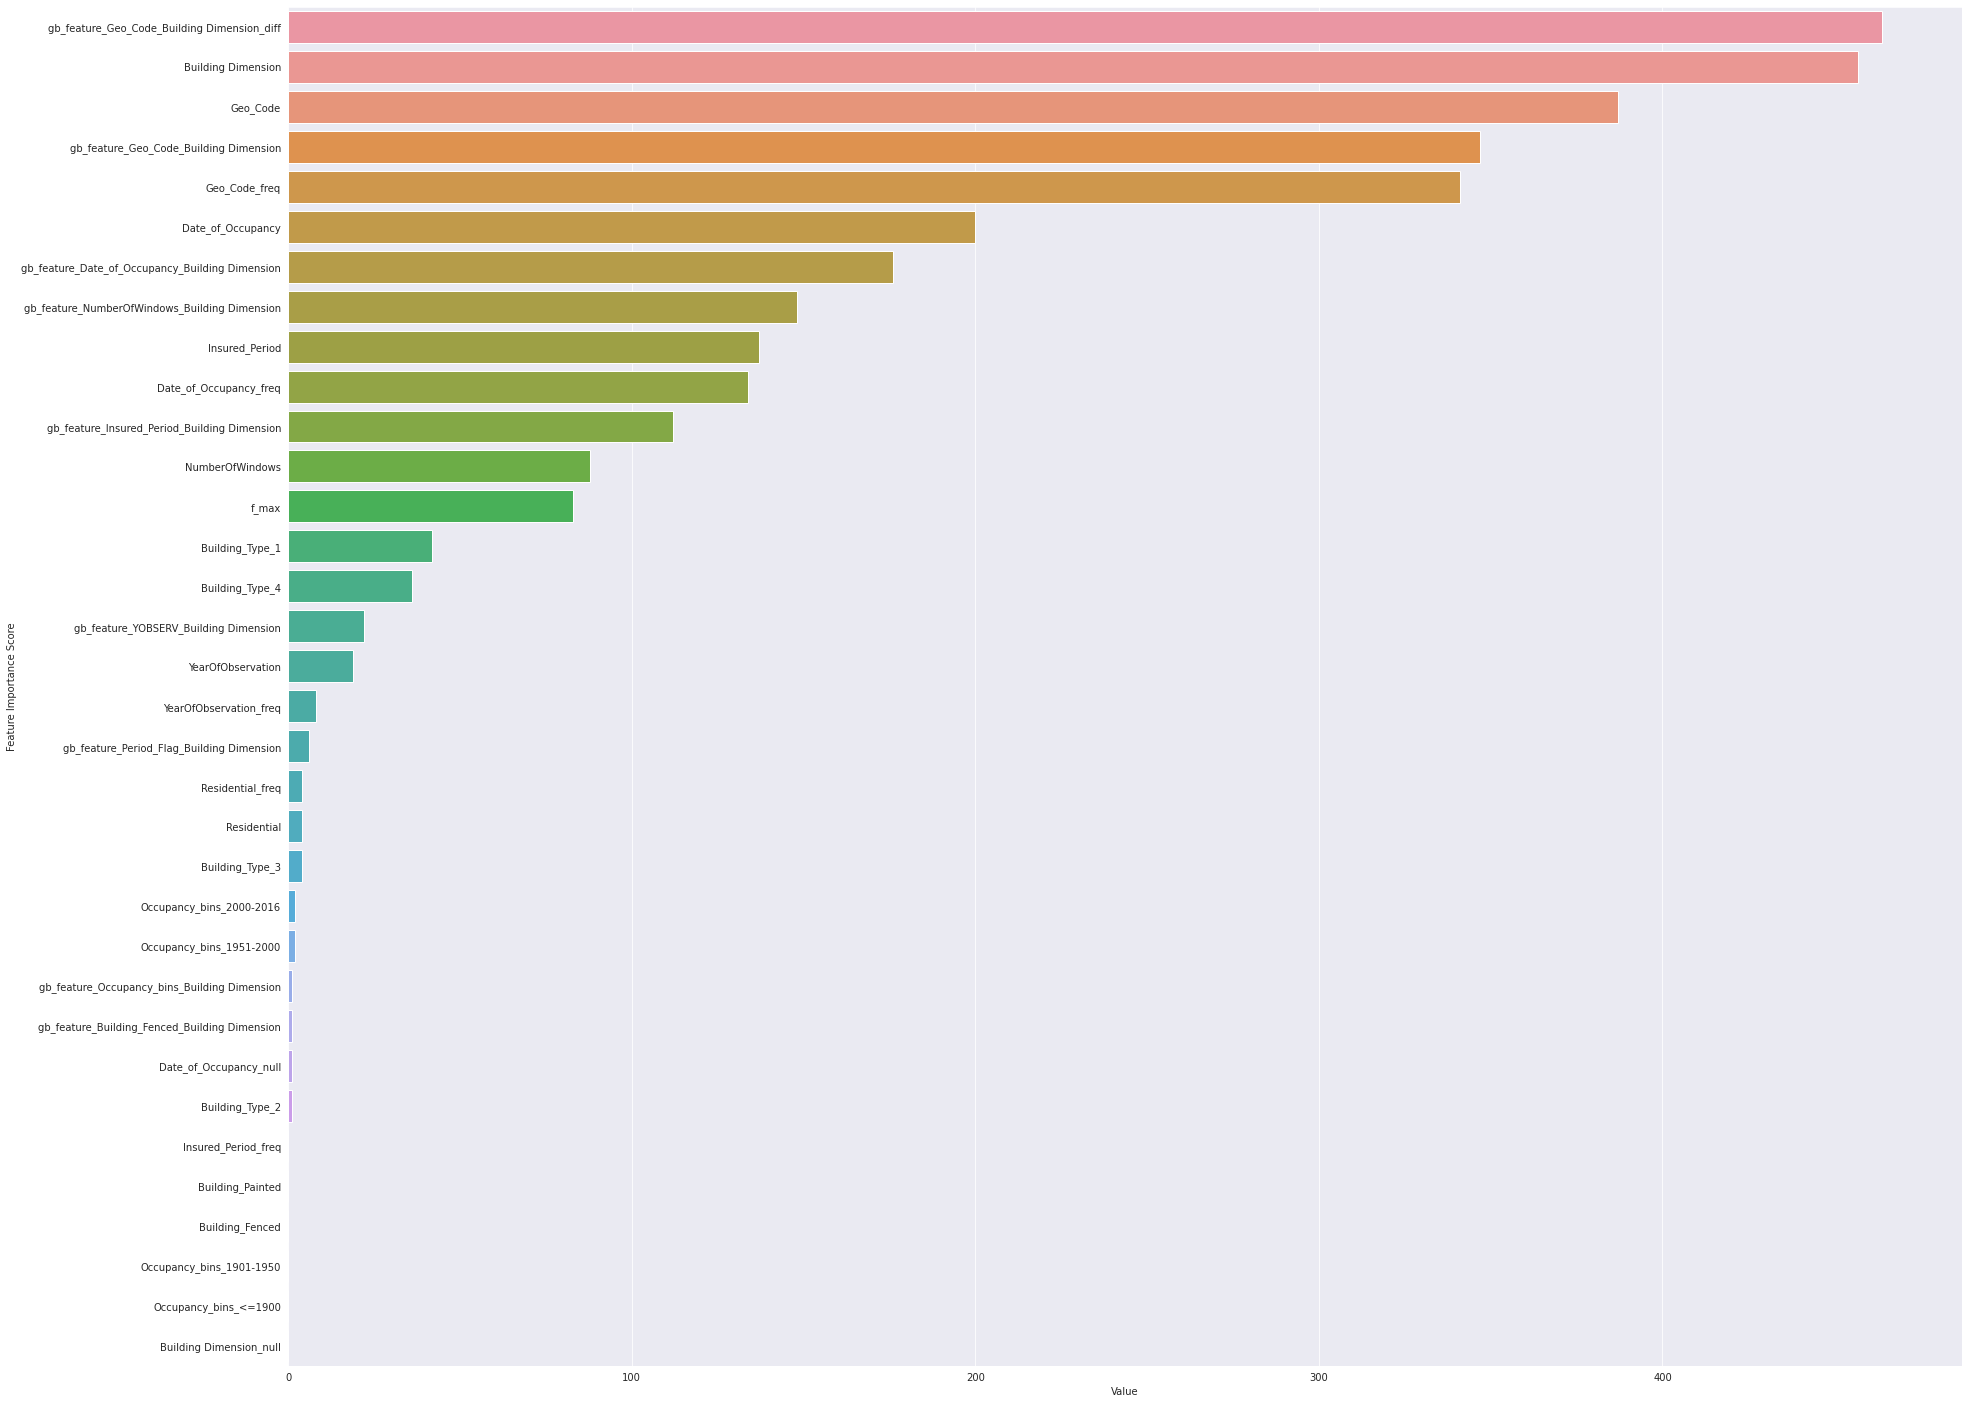

0.7168823998704991 0.8330943024691194 0.005706657244625673


In [15]:
lgb_model = lgb.LGBMClassifier( n_estimators=10000, metric='AUC', learning_rate=0.04, subsample=0.7,
                         colsample_bytree=0.8, num_leaves=64, reg_alpha=4, min_child_samples=5,subsample_freq=2)

func_= func(train, target, test, lgb_model, 'lgbm',64)
val_p3, test_p3, model3 = func_()

In [16]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1,val_p2,val_p3))
# stack = np.column_stack((val_p4,val_p5))
stack_p = np.column_stack((test_p1,test_p2,test_p3))
# stack_p = np.column_stack((test_p4,test_p5))
predict = LinearRegression().fit(stack, target).predict(stack_p)

In [17]:
submission.shape

(3069, 2)

In [18]:
submission['Claim'] = predict
submission.to_csv('solution_blended_reduced_gkfolds2.csv',index=False)

In [19]:
gc.collect()

17984

In [20]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1,val_p2))
# stack = np.column_stack((val_p4,val_p5))
stack_p = np.column_stack((test_p1,test_p2))
# stack_p = np.column_stack((test_p4,test_p5))
predict = LinearRegression().fit(stack, target).predict(stack_p)

In [21]:
submission['Claim'] = predict
submission.to_csv('solution_catboost_reduced_gkfolds2.csv',index=False)

In [22]:
submission.head()

,Customer Id,Claim
0,H11920,0.095418
1,H11921,0.068307
2,H9805,0.064440
3,H7493,0.124178
4,H7494,0.111675
